In [14]:
PRETRAINED_MODEL="prajjwal1/bert-small"
TASKS=["cola", "qnli", "qqp", "mnli"]

##  Load Pretrained Model 

Code for loading a pretrained BERT checkpoint

In [2]:
from transformers import BertForSequenceClassification

## Load Dataset

Loads the dataset for GLUE task

In [3]:
from datasets import load_dataset
from transformers import BertTokenizerFast

task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}

tokenizer = BertTokenizerFast.from_pretrained(PRETRAINED_MODEL)

datasets = {}
for task in TASKS:
    datasets[task] = load_dataset('glue', task)

Reusing dataset glue (/home/pfernand/.cache/huggingface/datasets/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

Reusing dataset glue (/home/pfernand/.cache/huggingface/datasets/glue/qnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

Reusing dataset glue (/home/pfernand/.cache/huggingface/datasets/glue/qqp/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

Reusing dataset glue (/home/pfernand/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
from transformers import DataCollatorWithPadding

def tokenize_function(examples, task, max_seq_length=512):
    # Tokenize the texts
    sentence1_key, sentence2_key = task_to_keys[task]
    args = (
        (examples[sentence1_key],) if sentence2_key is None else (examples[sentence1_key], examples[sentence2_key])
    )
    return tokenizer(*args, max_length=max_seq_length, truncation=True)

tokenized_datasets = {}
for task in TASKS:
    tokenized_datasets[task] = datasets[task].map(lambda e: tokenize_function(e, task=task), batched=True)
    
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [51]:
for task in TASKS:
    print(len(datasets[task]["train"]))

363846


## Finetune

In [12]:
from datasets import load_metric
import numpy as np

metrics = {task: load_metric("glue", task) for task in TASKS}

def compute_metrics(p, task):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.argmax(preds, axis=1)
    result = metrics[task].compute(predictions=preds, references=p.label_ids)
    if len(result) > 1:
        result["combined_score"] = np.mean(list(result.values())).item()
    return result

In [13]:
%%capture output

from transformers import Trainer, TrainingArguments
import torch

for task in TASKS:
    num_labels=len(datasets[task]["train"].features["label"].names)
    finetuned_path = f"{PRETRAINED_MODEL.split('/')[-1]}-ft-{task}"
    model = BertForSequenceClassification.from_pretrained(PRETRAINED_MODEL, num_labels=num_labels)
    
    training_args = TrainingArguments(
        output_dir = finetuned_path, 
        evaluation_strategy="epoch",
        save_strategy="no",
        per_device_train_batch_size=64,
    )

    trainer = Trainer(
        model,
        training_args,
        train_dataset=tokenized_datasets[task]["train"],
        eval_dataset=tokenized_datasets[task]["validation_matched" if task == "mnli" else "validation"],
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=lambda p: compute_metrics(p, task=task)
    )

    trainer.train()

    model.save_pretrained(finetuned_path)
    del model
    del trainer
    torch.cuda.empty_cache()

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /home/pfernand/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin fr

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 31.75 GiB total capacity; 30.36 GiB already allocated; 9.75 MiB free; 30.41 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [16]:
output.show()

{'label': 2, 'idx': 100, 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'hypothesis': 'The exhibition only displays cars from the 2000s.', 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'premise': 'It displays all kinds of vehicles, from the coach that carried Napoleon to and from Moscow in 1812 to a splendid 4-horsepower Renault car from 1904 and other turn-of-the-century classics.', 'input_ids': [101, 2009, 8834, 2035, 7957, 1997, 4683, 1010, 2013, 1996, 2873, 2008, 3344, 8891, 2000, 1998, 2013, 4924, 1999, 9842, 2000, 1037, 21459, 1018, 1011, 15149, 14605, 2482, 2013, 5692, 1998, 2060, 2735, 1011, 1997, 1011, 1996, 1011, 2301, 10002, 1012, 102, 1996, 4538, 2069, 8834, 3765, 2013, 1996, 8876, 1012, 102]}


## Evaluating on Squad

Code for running evaluation on finetuned model on squad

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizerFast
from transformers import Trainer, TrainingArguments
from timeit import default_timer as timer

for task in TASKS:
    finetuned_path = f"{PRETRAINED_MODEL.split('/')[-1]}-ft-{task}"
    model = BertForSequenceClassification.from_pretrained(finetuned_path)
    tokenizer = BertTokenizerFast.from_pretrained(PRETRAINED_MODEL)
    val_key = "validation_matched" if task == "mnli" else "validation"

    eval_args = TrainingArguments(
        output_dir = finetuned_path,
        do_train = False,
        do_predict = True,
        dataloader_drop_last = False,
    )

    trainer = Trainer(
        model,
        eval_args,
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=lambda p: compute_metrics(p, task=task)
    )
    start = timer()
    result = trainer.evaluate(eval_dataset=tokenized_datasets[task][val_key])
    end = timer()
    delta = end-start
    print(task)
    print(result)
    print(f"time per sample = {delta/len(tokenized_datasets[task][val_key])}")

## Quantitize the models

In [12]:
for task in TASKS:
    finetuned_path = f"{PRETRAINED_MODEL.split('/')[-1]}-ft-{task}"
    model = BertForSequenceClassification.from_pretrained(finetuned_path)
    qt_model = torch.quantization.quantize_dynamic(model, {torch.nn.Linear}, dtype=torch.qint8)
    qt_model.save_pretrained(f"{finetuned_path}-qt")

loading configuration file bert-small-ft-cola/config.json
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-small",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 2048,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 8,
  "num_hidden_layers": 4,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file bert-small-ft-cola/pytorch_model.bin
All model checkpoint weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification were initialized from the mo

In [33]:
from transformers import BertForSequenceClassification, BertTokenizerFast
from transformers import Trainer, TrainingArguments
from timeit import default_timer as timer

import numpy as np
from datasets import load_metric
from timeit import default_timer as timer
from torch.profiler import profile, record_function, ProfilerActivity

for task in TASKS:
    finetuned_path = f"{PRETRAINED_MODEL.split('/')[-1]}-ft-{task}"
    #model = BertForSequenceClassification.from_pretrained(finetuned_path)
    tokenizer = BertTokenizerFast.from_pretrained(PRETRAINED_MODEL)
    val_key = "validation_matched" if task == "mnli" else "validation"

    with profile(activities=[ProfilerActivity.CUDA, ProfilerActivity.CPU], profile_memory=True, record_shapes=True) as prof:
        with record_function("model_inference"):
            inputs = tokenized_datasets[task][val_key][0]
            model = BertForSequenceClassification.from_pretrained(finetuned_path).cuda()
            model.forward(
                input_ids=torch.tensor(inputs["input_ids"]).unsqueeze(0).cuda(), 
                token_type_ids=torch.tensor(inputs["token_type_ids"]).unsqueeze(0).cuda(), 
                attention_mask=torch.tensor(inputs["attention_mask"]).unsqueeze(0).cuda()
            )
    start = timer()
    eval_args = TrainingArguments(
        output_dir = finetuned_path,
        do_train = False,
        do_predict = True,
        dataloader_drop_last = False,
    )

    trainer = Trainer(
        model,
        eval_args,
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=lambda p: compute_metrics(p, task=task)
    )
    trainer.predict(tokenized_datasets[task][val_key])
    end = timer()
    delta = end-start
    print(prof.key_averages().table(sort_by="cuda_time_total"))
    print(f"time per sample = {delta/len(tokenized_datasets[task][val_key])}")

loading file https://huggingface.co/prajjwal1/bert-small/resolve/main/vocab.txt from cache at /home/pfernand/.cache/huggingface/transformers/68be80309844e53b628e9d479926a991d0adf337752bb941f0188887240313b8.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/prajjwal1/bert-small/resolve/main/tokenizer.json from cache at None
loading file https://huggingface.co/prajjwal1/bert-small/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/prajjwal1/bert-small/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/prajjwal1/bert-small/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/prajjwal1/bert-small/resolve/main/config.json from cache at /home/pfernand/.cache/huggingface/transformers/ac031779e2b4dd1d9da1e39c9d6a29fd45deea195eb3703a701d9c77f60abb4e.1257bb8f1f585038e86954d2560e36ca5c2dd98a8cde30fd22468940c911b672
Model c

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference         4.62%     113.382ms        99.83%        2.449s        2.449s       0.000us         0.00%      63.487ms      63.487ms     109.73 Mb      -4.30 Kb     110.12 Mb      -1.98 M

loading file https://huggingface.co/prajjwal1/bert-small/resolve/main/vocab.txt from cache at /home/pfernand/.cache/huggingface/transformers/68be80309844e53b628e9d479926a991d0adf337752bb941f0188887240313b8.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/prajjwal1/bert-small/resolve/main/tokenizer.json from cache at None
loading file https://huggingface.co/prajjwal1/bert-small/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/prajjwal1/bert-small/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/prajjwal1/bert-small/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/prajjwal1/bert-small/resolve/main/config.json from cache at /home/pfernand/.cache/huggingface/transformers/ac031779e2b4dd1d9da1e39c9d6a29fd45deea195eb3703a701d9c77f60abb4e.1257bb8f1f585038e86954d2560e36ca5c2dd98a8cde30fd22468940c911b672
Model c

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference         4.61%     100.623ms        99.79%        2.178s        2.178s       0.000us         0.00%      26.541ms      26.541ms     109.73 Mb      -4.75 Kb     110.12 Mb      -5.40 M

loading file https://huggingface.co/prajjwal1/bert-small/resolve/main/vocab.txt from cache at /home/pfernand/.cache/huggingface/transformers/68be80309844e53b628e9d479926a991d0adf337752bb941f0188887240313b8.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/prajjwal1/bert-small/resolve/main/tokenizer.json from cache at None
loading file https://huggingface.co/prajjwal1/bert-small/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/prajjwal1/bert-small/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/prajjwal1/bert-small/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/prajjwal1/bert-small/resolve/main/config.json from cache at /home/pfernand/.cache/huggingface/transformers/ac031779e2b4dd1d9da1e39c9d6a29fd45deea195eb3703a701d9c77f60abb4e.1257bb8f1f585038e86954d2560e36ca5c2dd98a8cde30fd22468940c911b672
Model c

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference         6.35%     149.698ms        99.55%        2.346s        2.346s       0.000us         0.00%      43.683ms      43.683ms     109.73 Mb      -4.44 Kb     109.74 Mb      -3.03 M

loading file https://huggingface.co/prajjwal1/bert-small/resolve/main/vocab.txt from cache at /home/pfernand/.cache/huggingface/transformers/68be80309844e53b628e9d479926a991d0adf337752bb941f0188887240313b8.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/prajjwal1/bert-small/resolve/main/tokenizer.json from cache at None
loading file https://huggingface.co/prajjwal1/bert-small/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/prajjwal1/bert-small/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/prajjwal1/bert-small/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/prajjwal1/bert-small/resolve/main/config.json from cache at /home/pfernand/.cache/huggingface/transformers/ac031779e2b4dd1d9da1e39c9d6a29fd45deea195eb3703a701d9c77f60abb4e.1257bb8f1f585038e86954d2560e36ca5c2dd98a8cde30fd22468940c911b672
Model c

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference         5.12%     120.392ms        99.99%        2.353s        2.353s       0.000us         0.00%      29.921ms      29.921ms     109.73 Mb      -4.37 Kb     110.13 Mb      -2.51 M

In [20]:
print(tokenized_datasets[task][val_key][0])

{'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'sentence': 'The sailors rode the breeze clear of the rocks.', 'idx': 0, 'label': 1, 'input_ids': [101, 1996, 11279, 8469, 1996, 9478, 3154, 1997, 1996, 5749, 1012, 102]}


## Divide Checkpoint

Code for dividing a checkpoint by layer

In [7]:
model.save_pretrained("ft-bert-base-uncased")

In [8]:
from checkpoint_divider import divide_checkpoint

divide_checkpoint("ft-bert-base-uncased/pytorch_model.bin", divided_checkpoint)

## Load Divided Checkpoint

In [3]:
def get_current_memory():
    import os, psutil
    process = psutil.Process(os.getpid())
    return process.memory_info().rss

In [6]:
import torch

print(torch.load(f"{divided_checkpoint}/layer2keys.bin"))
layers=[]
memory=[]
for layer in range(14):
    layers.append(torch.load(f"{divided_checkpoint}/pytorch_model_{layer}.bin"))
    memory.append(get_current_memory())

defaultdict(<class 'list'>, {0: ['bert.embeddings.LayerNorm.bias', 'bert.embeddings.LayerNorm.weight', 'bert.embeddings.position_embeddings.weight', 'bert.embeddings.position_ids', 'bert.embeddings.token_type_embeddings.weight', 'bert.embeddings.word_embeddings.weight'], 1: ['bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.dense.bias', 'bert.encoder.layer.0.attention.output.dense.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.encoder.layer.0.attention.self.key.weight', 'bert.encoder.layer.0.attention.self.query.bias', 'bert.encoder.layer.0.attention.self.query.weight', 'bert.encoder.layer.0.attention.self.value.bias', 'bert.encoder.layer.0.attention.self.value.weight', 'bert.encoder.layer.0.intermediate.dense.bias', 'bert.encoder.layer.0.intermediate.dense.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.enco

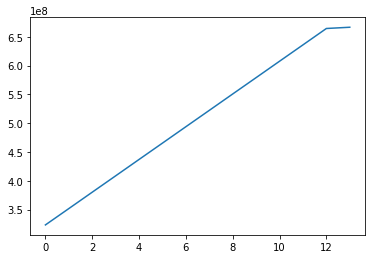

In [5]:
import matplotlib.pyplot as plt

plt.plot(memory)